# Universal bootstrap: a superpower

> _Look on my computational methods, ye theorists, and despair_

[Bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)) is a commonly used technique for computational statistics and machine learning. 
* [Uncertainty quantification](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)): an approximate distribution of a sample statistic (e.g., mean) is the empirical distribution of the same statistic calculated over bootstrap samples
* [Bootstrap tests](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)#Bootstrap_hypothesis_testing): a distribution-free hypothesis test by using the empirical distribution of the test statistic from bootstrap samples that randomize the test design
* [Bagging](https://en.wikipedia.org/wiki/Bootstrap_aggregating): improving accuracy and reducing variance of a learner by training the model on subsets of resampled 

So how _should_ you bootstrap? In an earlier post, I covered [universal sampling](https://patrick-nicholson.github.io/2023/02/13/universal-sampling/) and its advantages. In this post, I show how this can be extended with sampling with replacement to create the universal bootstrap.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

from IPython.display import Markdown
from scipy import stats
from sklearn.datasets import load_iris
from sklearn.linear_model import LinearRegression
from sklearn.utils.murmurhash import murmurhash3_32 as mmhash
from uuid import uuid4

%matplotlib inline

random_state = np.random.RandomState(12345)

## Key insight

Bootstrapping is based on sampling with replacement. [Poisson sampling](https://en.wikipedia.org/wiki/Poisson_sampling) is one such method. For a sample size $N$ and resampling size $S$, the resampling weights for each observation follows the $\text{Pois} \left( \frac{S}{N} \right)$ distribution. The [Poisson bootstrap](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)#Poisson_bootstrap), commonly used for bootstrapping streams and large datasets, is the particular case where $N = S$, i.e., $\text{Pois}(1)$.

In [my earlier post](https://patrick-nicholson.github.io/2023/02/13/universal-sampling/), I demonstrated a method of sampling from a Poisson distribution based on universal hash functions. Composing this with Poisson sampling gives us the universal bootstrap.

In short:
* A universal hash function deterministically maps an input to a uniformly distributed integer in the full integer range
* Uniform integers can be transformed into Poisson values
* Multiplying the hash value by another random integer yields an uncorrelated random integer
* Ergo, mapping the products of a hash value by $r$ random integers to $\text{Pois}(1)$ values provides $r$ deterministic bootstrap sample weights

In [2]:
def poisson_thresholds(lam, tol=None):
    """Threshold values (32-bit integers) for Poisson inverse transformation"""

    tol = tol or 1e-6
    pois = stats.poisson(lam)
    lower, upper = np.ceil(pois.isf([1 - tol, tol])).astype(
        np.int32
    )
    edges = (
        pois.cdf(np.arange(lower, upper)) * 2**32 - 2**31
    ).astype(np.int32)

    # compress int.min
    lower += (edges == -(2**31)).sum()
    edges = edges[edges > -(2**31)]

    # compress int.max
    edges = np.r_[edges[edges < 2**31 - 1], 2**31 - 1]
    upper = lower + len(edges) - 1

    return lower, upper, edges


def inverse_transform_search(thresholds, hash_values):
    """Inverse transform search with correction to thin out tails when there are duplicated thresholds"""
    left = np.searchsorted(thresholds, hash_values, side="left")
    right = np.searchsorted(
        thresholds, hash_values, side="right"
    )
    return np.where(hash_values < 0, right, left)


def poisson_sample_weight(hashes, lam, tol=None):
    """Poisson weights for an array of hashes"""
    lower, _, edges = poisson_thresholds(lam, tol)
    return inverse_transform_search(edges, hashes) + lower

## Baby's first bootstrap

The first thing a little data scientist learns to do with a bootstrap is to estimate a distribution around some sample statistic. Let's use our old friend `iris` for this.

In [3]:
bootstrap_replications = 200

_ = load_iris(as_frame=True)
iris = pd.concat([_["target"], _["data"]], axis=1)
iris.columns = ["_".join(k.split()[:2]) for k in iris]

iris.head()

,target,sepal_length,sepal_width,petal_length,petal_width
0,0,5.1,3.5,1.4,0.2
1,0,4.9,3.0,1.4,0.2
2,0,4.7,3.2,1.3,0.2
3,0,4.6,3.1,1.5,0.2
4,0,5.0,3.6,1.4,0.2


We use this to estimate some sample statistic.

In [4]:
iris["sepal_length"].mean()

5.843333333333334

A single bootstrap estimate is the same statistic applied to a resampled from the data. The empirical distribution of many different bootstrap replications is the bootstrap distribution of the statistic.

In [5]:
iris["sepal_length"].sample(frac=1.0, replace=True).mean()

5.8580000000000005

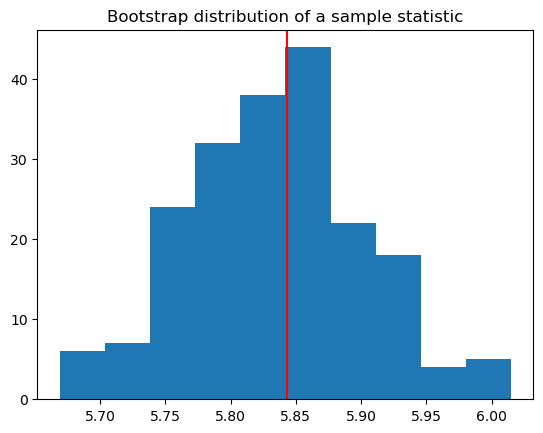

In [6]:
n = len(iris)

baby_null = (
    iris["sepal_length"]
    .sample(
        frac=bootstrap_replications,
        replace=True,
        ignore_index=True,
    )
    .groupby(lambda i: i // n)
    .mean()
)

fig, ax = plt.subplots()
ax.hist(baby_null)
ax.axvline(iris["sepal_length"].mean(), c="red")
ax.set_title("Bootstrap distribution of a sample statistic");

A single universal bootstrap estimate is the sample statistic weighted by Poisson weights. The universal bootstrap distribution repeats this by randomizing the hashes and repeating the weighting process.

In [7]:
baby_hashes = mmhash(iris.index.values.astype(np.int32))
np.average(
    iris["sepal_length"],
    weights=poisson_sample_weight(baby_hashes, 1),
)

5.938410596026489

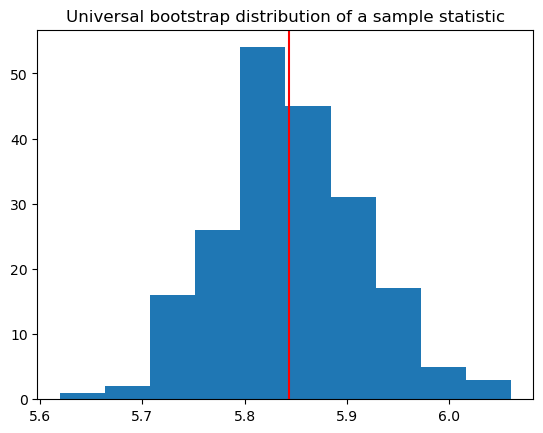

In [8]:
randomization = random_state.randint(
    -(2**31), 2**31, bootstrap_replications, dtype=np.int32
)
baby_weights = poisson_sample_weight(
    np.multiply.outer(baby_hashes, randomization), 1
)
poisson_baby_null = (
    baby_weights * iris["sepal_length"].values[:, None]
).sum(axis=0) / baby_weights.sum(axis=0)

fig, ax = plt.subplots()
ax.hist(poisson_baby_null)
ax.axvline(iris["sepal_length"].mean(), c="red")
ax.set_title(
    "Universal bootstrap distribution of a sample statistic"
);

Of course, you can also do this by repeating observations based on the Poisson weights.

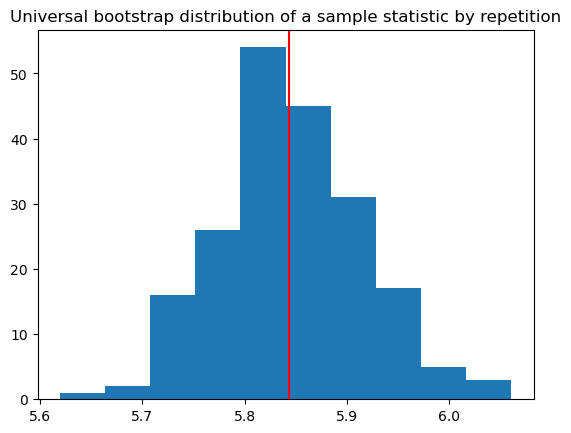

In [9]:
values = np.tile(iris["sepal_length"], bootstrap_replications)
baby_weights = baby_weights.T.ravel()
replications = np.repeat(
    np.arange(bootstrap_replications), len(iris)
)
values, baby_weights, replications = (
    values[baby_weights > 0],
    baby_weights[baby_weights > 0],
    replications[baby_weights > 0],
)

repeated_estimates = (
    pd.Series(np.repeat(values, baby_weights))
    .groupby(np.repeat(replications, baby_weights))
    .mean()
)

fig, ax = plt.subplots()
ax.hist(repeated_estimates)
ax.axvline(iris["sepal_length"].mean(), c="red")
ax.set_title(
    "Universal bootstrap distribution of a sample statistic by"
    " repetition"
);

## Universal bootstrap for hypothesis testing

While baby's first bootstrap was fun and all, the practical power of bootstrapping is really revealed when estimating the $H_0$ distribution of a hypothesis test. 

Given a sample of $N = n^T + n^C$ units with $n^T$ test units and $n^C$ control units, a single bootstrap iteration samples (with replacement) pseudo-test and pseudo-control groups; each pseudo group is (approximately) the same size as the true group. That is, we randomly assign (with replacement) each unit to the pseudo groups. The iteration's sample statistic (e.g., difference in means) is then calculated from the pseudo groups.

Let's simulate as simple experiment where an offer creates an average standardize effect of .1 on purchases.

In [10]:
# number of customers
num_customers = 10**5

# percent of customers that received an offer
test_percent_offer = 0.35

# true effect of offer on standardized purchases
true_effect_offer = 0.1

# purchases across customers
# - customer_uuid: a UUID4 for the customer
# - customer_numeric_id: a serial ID for the customer
# - received_offer: customer received an offer (binary)
# - purchases: standardized purchases
purchases = pd.DataFrame(
    [
        (
            str(uuid4()),
            numeric_id,
            received_offer,
            purchases + received_offer * offer_effect,
        )
        for numeric_id, (
            received_offer,
            purchases,
            offer_effect,
        ) in enumerate(
            zip(
                random_state.binomial(
                    1, test_percent_offer, num_customers
                ),
                random_state.normal(0, 1, num_customers),
                random_state.normal(
                    true_effect_offer,
                    true_effect_offer,
                    num_customers,
                ),
            )
        )
    ],
    columns=[
        "customer_uuid",
        "customer_numeric_id",
        "received_offer",
        "purchases",
    ],
)

The universal bootstrap is changed only slightly: we now generate test and control weights according to their sample sizes. Each replication has pseudo-test and pseudo-control samples, from which we calculate the test value.

In [11]:
test_randomization, control_randomization = random_state.randint(
    -(2**31), 2**31, (2, bootstrap_replications), np.int32
)

The test is then comparing the null distribution to the observed statistic from the true test and control groups.

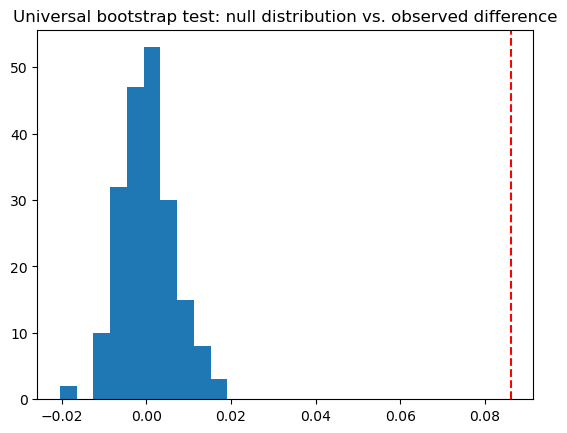

In [12]:
offer_hashes = (
    purchases["customer_uuid"]
    .map(mmhash)
    .values.astype(np.int32)
)

test_weights = poisson_sample_weight(
    np.multiply.outer(offer_hashes, test_randomization),
    test_percent_offer,
)
test = (test_weights.T * purchases["purchases"].values).sum(
    axis=1
) / test_weights.sum(axis=0)
del test_weights

control_weights = poisson_sample_weight(
    np.multiply.outer(offer_hashes, control_randomization),
    1.0 - test_percent_offer,
)
control = (
    control_weights.T * purchases["purchases"].values
).sum(axis=1) / control_weights.sum(axis=0)
del control_weights

offer_null_distribution = test - control

control, test = purchases.groupby("received_offer")[
    "purchases"
].mean()
offer_point_est = test - control

fig, ax = plt.subplots()
ax.hist(offer_null_distribution)
ax.axvline(offer_point_est, color="red", ls="--")
ax.set_title(
    "Universal bootstrap test: null distribution vs. observed"
    " difference"
);

What if we have a more complicated experiment? Consider an educational intervention:
* A test is taken twice
* An intervention is applied to some classes after the first test
* Classes are not identical: they have different average test scores
* Test scores improve over time 

This is intentionally set up for a difference-in-differences design.

In [13]:
# number of classes
num_classes = 100

# average number of students in a class
avg_students = 25

# average test scores differ between classes
between_class_sd = 0.1

# students improve on the test over time
true_trend = 0.1

# percent of classes receiving an intervention
test_percent_class = 0.75

# true effect of the intervention on standardized test scores
true_effect_intervention = 0.05

# test scores in two periods for students within classes
# - class_id: unique class identifier
# - student_num: anonymous student number within class
# - intervention_class: class received intervention (binary)
# - post_period: score is for the second test (post intervention, if received)
# - score: standardized test score
test_scores = pd.DataFrame(
    [
        (
            class_id,
            student_num,
            intervention_class,
            post_period,
            start_score
            + post_period * trend
            + post_period
            * intervention_class
            * intervention_effect,
        )
        for class_id, (
            students,
            class_avg_score,
            intervention_class,
        ) in enumerate(
            zip(
                random_state.poisson(avg_students, num_classes),
                random_state.normal(
                    0, between_class_sd, num_classes
                ),
                random_state.binomial(
                    1, test_percent_class, num_classes
                ),
            )
        )
        for student_num, (
            start_score,
            intervention_effect,
        ) in enumerate(
            zip(
                random_state.normal(
                    class_avg_score, 1, students
                ),
                random_state.normal(
                    true_effect_intervention,
                    true_effect_intervention / 2.8,
                    students,
                ),
            )
        )
        for post_period, trend in enumerate(
            random_state.normal(true_trend, true_trend / 2.8, 2)
        )
    ],
    columns=[
        "class_id",
        "student_num",
        "intervention_class",
        "post_period",
        "score",
    ],
)

Correct measurement requires correct specification of standard errors. Standard covariances are too large to draw the correct inference; clustered standard errors are necessary.

In [14]:
fit = smf.ols(
    "score ~ intervention_class * post_period", test_scores
).fit()
fit.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
No. Observations:                5034   F-statistic:                     10.26
Covariance Type:            nonrobust   Prob (F-statistic):           9.91e-07
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          0.0911      0.040      2.277      0.023       0.013       0.170
intervention_class                -0.1029      0.046     -2.239      0.025      -0.193      -0.013
post_period                        0.0986      0.057      1.741      0.082      -0.012       0.210
intervention_class:post_period     0.0517      0.065      0.795      0.426      -0.076       0.179
==================================================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
fit.get_robustcov_results(
    cov_type="cluster", groups=test_scores["class_id"]
).summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
No. Observations:                5034   F-statistic:                 1.057e+04
Covariance Type:              cluster   Prob (F-statistic):          6.46e-124
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          0.0911      0.039      2.342      0.021       0.014       0.168
intervention_class                -0.1029      0.048     -2.131      0.036      -0.199      -0.007
post_period                        0.0986      0.001     82.473      0.000       0.096       0.101
intervention_class:post_period     0.0517      0.002     33.734      0.000       0.049       0.055
==================================================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

As universal bootstrap is based on universal sampling, it is  straightforward to implement complex designs. In this case, the intervention is applied at the class level, so we hash the class ID.

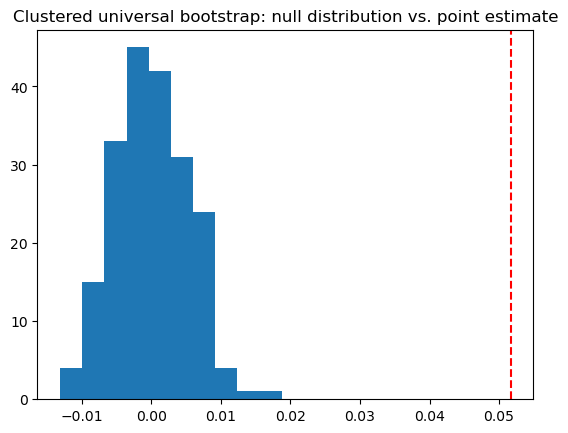

In [16]:
edu_hashes = mmhash(
    test_scores["class_id"].values.astype(np.int32)
)
edu_null = np.zeros(bootstrap_replications)

for i, random in enumerate(
    np.vstack([test_randomization, control_randomization]).T
):
    test_random, control_random = np.multiply.outer(
        edu_hashes, random
    ).T
    test_weights = poisson_sample_weight(
        test_random, test_percent_class
    )
    control_weights = poisson_sample_weight(
        control_random, 1 - test_percent_class
    )

    df = (
        pd.concat(
            [
                test_scores.assign(test=1, weight=test_weights),
                test_scores.assign(
                    test=0, weight=control_weights
                ),
            ]
        )
        .query("weight > 0")
        .eval("test_post = test * post_period")
    )

    ols = LinearRegression().fit(
        df[["test", "post_period", "test_post"]], df["score"]
    )
    edu_null[i] = ols.coef_[-1]

edu_point_est = fit.params["intervention_class:post_period"]

fig, ax = plt.subplots()
ax.hist(edu_null)
ax.axvline(edu_point_est, color="red", ls="--")
ax.set_title(
    "Clustered universal bootstrap: null distribution vs. point"
    " estimate"
);

## Wrapping up

Universal bootstrap is simply the application of Poisson bootstrap leveraging the strengths of universal sampling. It provides true determinism; efficiency in dataset or streams of any size; and straightforward application of complex sampling designs. In my next post, I'll cover how this can be done in SQL.